# Simple Reversal Strategy

## Strategy

This notebook demonstrates several variations of a basic cross-sectional strategy using a simple reversal signal to set weights in a dollar-neutral portfolio of cryptocurrencies. Under the hypothesis that cryptocurrencies with strong returns relative to other cryptocurrencies over a trading period will experience a price correction in the short-term (and correspondingly for cryptocurrencies with poor returns over a period), we test this with several variations of the processed signal:
- frequency of signal calculation:
  - 4 hours
  - 8 hours
  - 12 hours
  - 24 hours
  - 48 hours
- trade frequency (restricted to multiples of signal calculation):
  - 4 hours
  - 8 hours
  - 12 hours
  - 24 hours
  - 48 hours
- signal processing:
  - the original signal
  - winsorized signal
  - truncated signal
  - rank-thresholded signal
  - inverse CDF of the standard normal distribution applied to signal
- size of processing operation (for winsorized signal, truncated signal, and rank-thresholded signal only)
  - top and bottom 2%
  - top and bottom 5%
  - top and bottom 10%
  - top and bottom 20%
- ranking type during processing
  - rank, demean, and normalize the signal
  - only demean and normalize the signal
  

## Data Collection

The universe of cryptocurrencies is based on [this snapshot](https://coinmarketcap.com/historical/20201220/) from December 20, 2020 of major crytocurrencies. We use this set of cryptocurrencies to avoid survivor bias, with the period from December 20, 2020 to December 31, 2023 being the period when we try the different variations. We then test the three best performing variations of the strategy during the period form January 1, 2024 to August 31, 2025.


## Implementation

Most functions used here are defined in [this utility functions file](https://github.com/wbchristerson/crypto-strategies/blob/main/utility_functions.ipynb). Below, we implement a grid search over the parameter variations.


## Transaction Costs

We account for commissions and slippage by assuming 20 basis points of cost per dollar of turnover.


## Results

As shown in the table under the "Grid Search" section, the best results were for the following variations:

- Variation 1:
  - signal calculation frequency: 24 hours
  - trade frequency: 24 hours
  - signal type: rank threshold
  - rank type: ranked
  - operational parameter (proportion to rank-threshold): 0.02
- Variation 2:
  - signal calculation frequency: 24 hours
  - trade frequency: 24 hours
  - signal type: rank threshold
  - rank type: not ranked
  - operational parameter (proportion to rank-threshold): 0.02
- Variation 3:
  - signal calculation frequency: 12 hours
  - trade frequency: 48 hours
  - signal type: rank threshold
  - rank type: not ranked
  - operational parameter (proportion to rank-threshold): 0.05
  

Over the training period, the results were as follows:

| Statistic | Variation 1 | Variation 2 | Variation 3 |
| :--- | :---: | :---: | ---: |
| avg returns | 2.103431 | 2.027339 | 1.353102 |
| decorrelated avg returns | 2.093676 | 2.017282 | 1.336768 |
| volatility | 1.198657 | 1.189359 | 0.802799 |
| sharpe ratio | 1.754823 | 1.704564 | 1.685480 |
| decorrelated sharpe ratio | 1.746115 | 1.695565 | 1.664827 |
| max drawdown | -20.474390 | -20.474390 | -7.701955 |
| max drawdown duration | 289.000000 | 291.000000 | 182.000000 |
| alpha_BTC | 0.005744 | 0.005534 | 0.007340 |
| beta_BTC | 0.028983 | 0.029559 | 0.046078 |

Following this, over the testing period, the results were as below:

| Statistic | Variation 1 | Variation 2 | Variation 3 |
| :--- | :---: | :---: | ---: |
| avg returns | 7.498951 | 7.816893 | 3.451894 |
| decorrelated avg returns | 7.464656 | 7.765432 | 3.401973 |
| volatility | 0.980739 | 1.009071 | 0.564995 |
| sharpe ratio | 7.646228 | 7.746623 | 6.109599 |
| decorrelated sharpe ratio | 7.721693 | 1.695565 | 6.029614 |
| max drawdown | -5.669954 | -1.087484 | -0.307030 |
| max drawdown duration | 47.000000 | 35.000000 | 30.000000 |
| alpha_BTC | 0.020470 | 0.021284 | 0.018625 |
| beta_BTC | 0.115622 | 0.144228 | 0.093919 |

The first variation has the highest sharpe ratio during the testing period but it also has the largest maximum drawdown. The third variation maintains a high sharpe ratio with a much smaller maximum drawdown and maximum drawdown duration. The decorrelated sharpe ratio (using a portfolio just holding Bitcoin as a benchmark) is roughly the same suggesting little exposure to the market (dominated by Bitcoin), as expected since the strategy is market neutral.

# Imports

In [2]:
import pandas as pd

from ipynb.fs.full.utility_functions import (
    get_price_data,
    get_horizon_to_px_4h,
    get_winsorized_signal,
    get_demeaned_normalized_signal,
    get_rank_demeaned_normalized_signal,
    get_train_test_data,
    get_gross_returns_and_net_returns,
    get_truncated_signal,
    get_rank_thresholded_signal,
    get_inverse_cdf_standard_normal_signal,
    plot_gross_and_net_cumulative_returns,
    get_strategy_stats,
)
from datetime import datetime

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Price Data Collection

In [3]:
univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

px = get_price_data(univ, '4h', True, './class_project_input_prices.csv')
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


# Grid Search

In [4]:
t = datetime(2024, 1, 1, 0, 0)
train_px, test_px = get_train_test_data(px, t)

In [5]:
from enum import Enum

class SignalType(Enum):
    DEFAULT = 1
    WINSORIZE = 2
    TRUNCATE = 3
    RANK_THRESHOLD = 4
    INVERSE_CDF = 5


class RankType(Enum):
    RANKED = 1
    NOT_RANKED = 2


horizon_to_px_4h = get_horizon_to_px_4h(train_px)


def remove_missing_trade_times(trade_times, horizon_px_index):
    used_trade_times = []
    for trade_time in trade_times:
        if trade_time in horizon_px_index:
            used_trade_times.append(trade_time)
    return used_trade_times


def get_variant_gross_and_net_returns(
    signal_calc_freq,
    horizon_px,
    trade_freq,
    signal_type, 
    rank_type,
    op_param
):
    ret = horizon_px / horizon_px.shift() - 1
    simple_raw_reversal_signal = ret * -1
    
    if signal_type == SignalType.DEFAULT:
        modified_signal = simple_raw_reversal_signal
    elif signal_type == SignalType.WINSORIZE:
        modified_signal = get_winsorized_signal(simple_raw_reversal_signal, op_param, op_param)
    elif signal_type == SignalType.TRUNCATE:
        modified_signal = get_truncated_signal(simple_raw_reversal_signal, op_param, op_param)
    elif signal_type == SignalType.RANK_THRESHOLD:
        modified_signal = get_rank_thresholded_signal(simple_raw_reversal_signal, op_param, op_param)
    elif signal_type == SignalType.INVERSE_CDF:
        modified_signal = get_inverse_cdf_standard_normal_signal(simple_raw_reversal_signal)

    if rank_type == RankType.RANKED:
        transformed_signal = get_rank_demeaned_normalized_signal(modified_signal)
    elif rank_type == RankType.NOT_RANKED:
        transformed_signal = get_demeaned_normalized_signal(modified_signal)
    
    start_time = horizon_px.index[0]
    end_time = horizon_px.index[-1]
    
    trade_times = pd.date_range(start=start_time, end=end_time, freq= (str(trade_freq) + 'h'))
    trade_times = remove_missing_trade_times(trade_times, horizon_px.index)
    
    traded_signal = transformed_signal.loc[trade_times]
    traded_price = horizon_px.loc[trade_times]
    
    return *get_gross_returns_and_net_returns(traded_signal, traded_price), traded_price


def update_result_stats(
    result_stats,
    signal_calc_freq,
    horizon_px,
    trade_freq,
    signal_type,
    rank_type,
    op_param
):
    gross_returns, net_returns, traded_price = get_variant_gross_and_net_returns(
        signal_calc_freq,
        horizon_px,
        trade_freq,
        signal_type, 
        rank_type,
        op_param
    )
    
    key = (signal_calc_freq, trade_freq, signal_type, rank_type, op_param)
    result_stats[key] = get_strategy_stats(net_returns, trade_freq, traded_price)


training_result_stats = dict()

for signal_calc_freq in (4, 8, 12, 24, 48):
    for trade_freq in (4, 8, 12, 24, 48):
        if trade_freq % signal_calc_freq != 0:
            continue
        
        for signal_type in (
            SignalType.DEFAULT, SignalType.WINSORIZE, SignalType.TRUNCATE, SignalType.RANK_THRESHOLD,
            SignalType.INVERSE_CDF
        ):
            for operational_parameter in (0.02, 0.05, 0.10, 0.20):
                if operational_parameter != 0.02 and \
                    signal_type in (SignalType.DEFAULT, SignalType.INVERSE_CDF):
                    continue
                
                # amount to winsorize, truncate or rank-threshold by
                for rank_type in (RankType.RANKED, RankType.NOT_RANKED):
                    update_result_stats(
                        training_result_stats,
                        signal_calc_freq,
                        horizon_to_px_4h[signal_calc_freq],
                        trade_freq,
                        signal_type,
                        rank_type,
                        operational_parameter
                    )

training_result_df = pd.DataFrame(training_result_stats).T

In [6]:
training_result_df.sort_values(by="sharpe ratio", ascending=False).iloc[:20]

avg returns  \
24 24 SignalType.RANK_THRESHOLD RankType.RANKED     0.02     2.103431   
                                RankType.NOT_RANKED 0.02     2.027339   
12 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.05     1.353102   
24 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.02     1.627512   
12 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.10     1.043011   
24 48 SignalType.RANK_THRESHOLD RankType.RANKED     0.02     1.563365   
4  48 SignalType.RANK_THRESHOLD RankType.RANKED     0.02     1.487440   
24 24 SignalType.RANK_THRESHOLD RankType.RANKED     0.05     1.349546   
12 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.20     0.898204   
24 48 SignalType.RANK_THRESHOLD RankType.RANKED     0.05     1.067559   
                                RankType.NOT_RANKED 0.05     1.148899   
12 24 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.05     1.188611   
   48 SignalType.DEFAULT        RankType.NOT_RANKED 0.02     0.661114   
      SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.02     1.256857   
                                RankType.RANKED     0.02     1.275949   
24 48 SignalType.DEFAULT        RankType.NOT_RANKED 0.02     0.663337   
   24 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.05     1.300720   
4  48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.02     1.316220   
24 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.20     0.764492   
   24 SignalType.DEFAULT        RankType.NOT_RANKED 0.02     0.780921   

                                                          decorrelated avg returns  \
24 24 SignalType.RANK_THRESHOLD RankType.RANKED     0.02                  2.093676   
                                RankType.NOT_RANKED 0.02                  2.017282   
12 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.05                  1.336768   
24 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.02                  1.630618   
12 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.10                  1.023448   
24 48 SignalType.RANK_THRESHOLD RankType.RANKED     0.02                  1.568354   
4  48 SignalType.RANK_THRESHOLD RankType.RANKED     0.02                  1.438272   
24 24 SignalType.RANK_THRESHOLD RankType.RANKED     0.05                  1.331192   
12 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.20                  0.874035   
24 48 SignalType.RANK_THRESHOLD RankType.RANKED     0.05                  1.063454   
                                RankType.NOT_RANKED 0.05                  1.144155   
12 24 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.05                  1.194718   
   48 SignalType.DEFAULT        RankType.NOT_RANKED 0.02                  0.638282   
      SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.02                  1.239443   
                                RankType.RANKED     0.02                  1.261654   
24 48 SignalType.DEFAULT        RankType.NOT_RANKED 0.02                  0.652877   
   24 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.05                  1.291096   
4  48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.02                  1.261203   
24 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.20                  0.758388   
   24 SignalType.DEFAULT        RankType.NOT_RANKED 0.02                  0.765420   

                                                          volatility  \
24 24 SignalType.RANK_THRESHOLD RankType.RANKED     0.02    1.198657   
                                RankType.NOT_RANKED 0.02    1.189359   
12 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.05    0.802799   
24 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.02    0.977359   
12 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.10    0.651752   
24 48 SignalType.RANK_THRESHOLD RankType.RANKED     0.02    0.993984   
4  48 SignalType.RANK_THRESHOLD RankType.RANKED     0.02    1.025855   
24 24 SignalType.RANK_THRESHOLD RankType.RANKED     0.05    0.944103   
12 48 SignalType.RANK_THRESHOLD RankType.NOT_RANKED 0.20    0.650557 

Top variations in the training period:
- Variation 1:
  - signal calculation frequency: 24 hours
  - trade frequency: 24 hours
  - signal type: rank threshold
  - rank type: ranked
  - operational parameter (proportion to rank-threshold): 0.02
- Variation 2:
  - signal calculation frequency: 24 hours
  - trade frequency: 24 hours
  - signal type: rank threshold
  - rank type: not ranked
  - operational parameter (proportion to rank-threshold): 0.02
- Variation 3:
  - signal calculation frequency: 12 hours
  - trade frequency: 48 hours
  - signal type: rank threshold
  - rank type: not ranked
  - operational parameter (proportion to rank-threshold): 0.05

# Variation 1

## Training Period

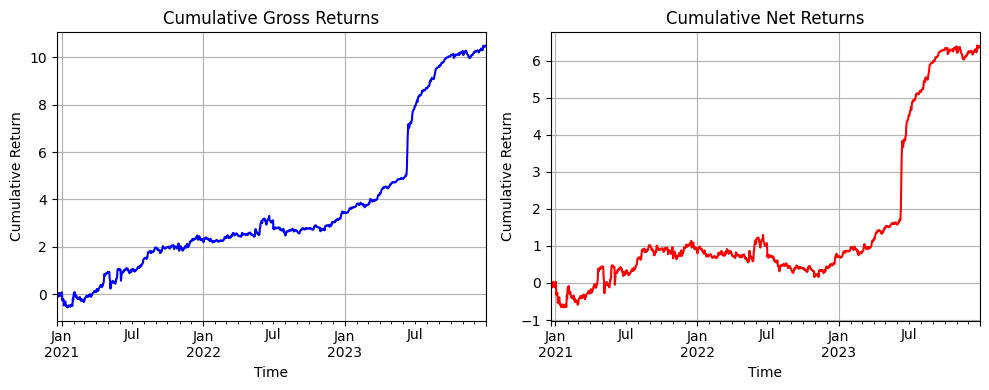

In [7]:
gross_returns, net_returns, traded_prices = get_variant_gross_and_net_returns(
    24, horizon_to_px_4h[24], 24, SignalType.RANK_THRESHOLD, RankType.RANKED, 0.02
)

plot_gross_and_net_cumulative_returns(gross_returns, net_returns)

In [8]:
pd.Series(get_strategy_stats(net_returns, 24, traded_prices)).to_frame()

,0
avg returns,2.103431
decorrelated avg returns,2.093676
volatility,1.198657
sharpe ratio,1.754823
decorrelated sharpe ratio,1.746115
max drawdown,-20.474390
max drawdown duration,289.000000
alpha_BTC,0.005744
beta_BTC,0.028983


## Testing Period

In [9]:
horizon_to_px_total_period = get_horizon_to_px_4h(px)

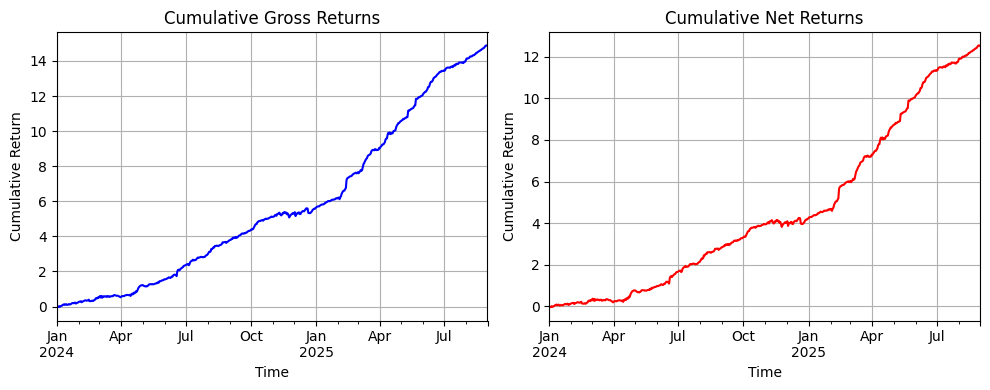

In [10]:
gross_returns, net_returns, traded_prices = get_variant_gross_and_net_returns(
    24, horizon_to_px_total_period[24], 24, SignalType.RANK_THRESHOLD, RankType.RANKED, 0.02
)

test_gross_returns = gross_returns.loc[t:]
test_net_returns = net_returns.loc[t:]

plot_gross_and_net_cumulative_returns(test_gross_returns, test_net_returns)

In [11]:
pd.Series(get_strategy_stats(test_net_returns, 24, traded_prices.loc[t:])).to_frame()

,0
avg returns,7.498951
decorrelated avg returns,7.464656
volatility,0.980739
sharpe ratio,7.646228
decorrelated sharpe ratio,7.629550
max drawdown,-5.669954
max drawdown duration,47.000000
alpha_BTC,0.020470
beta_BTC,0.115622


# Variation 2

## Training Period

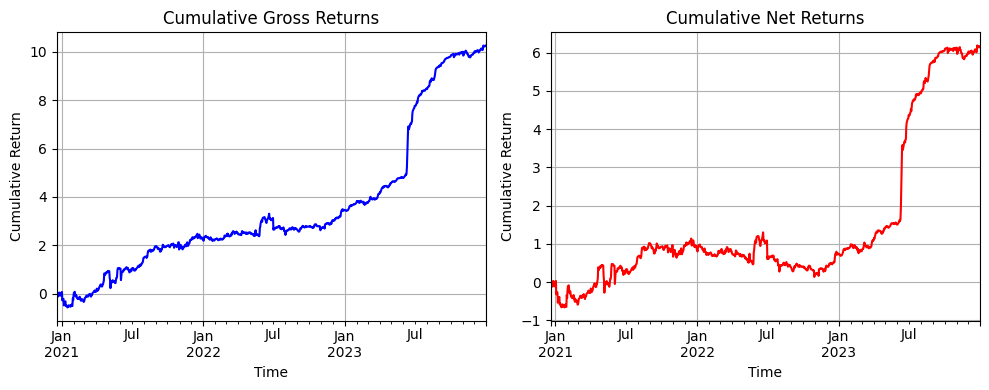

In [12]:
gross_returns, net_returns, traded_prices = get_variant_gross_and_net_returns(
    24, horizon_to_px_4h[24], 24, SignalType.RANK_THRESHOLD, RankType.NOT_RANKED, 0.02
)

plot_gross_and_net_cumulative_returns(gross_returns, net_returns)

In [13]:
pd.Series(get_strategy_stats(net_returns, 24, traded_prices)).to_frame()

,0
avg returns,2.027339
decorrelated avg returns,2.017282
volatility,1.189359
sharpe ratio,1.704564
decorrelated sharpe ratio,1.695565
max drawdown,-20.474390
max drawdown duration,291.000000
alpha_BTC,0.005534
beta_BTC,0.029559


## Testing Period

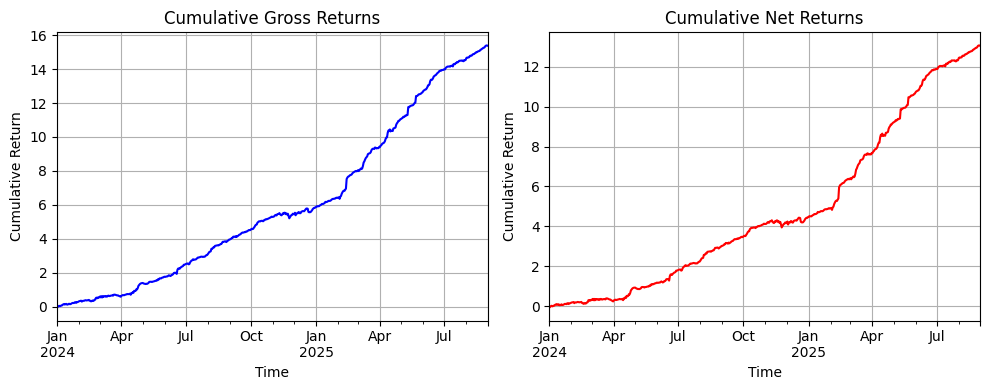

In [14]:
gross_returns, net_returns, traded_prices = get_variant_gross_and_net_returns(
    24, horizon_to_px_total_period[24], 24, SignalType.RANK_THRESHOLD, RankType.NOT_RANKED, 0.02
)

test_gross_returns = gross_returns.loc[t:]
test_net_returns = net_returns.loc[t:]

plot_gross_and_net_cumulative_returns(test_gross_returns, test_net_returns)

In [15]:
pd.Series(get_strategy_stats(test_net_returns, 24, traded_prices.loc[t:])).to_frame()

,0
avg returns,7.816893
decorrelated avg returns,7.765432
volatility,1.009071
sharpe ratio,7.746623
decorrelated sharpe ratio,7.721693
max drawdown,-1.087484
max drawdown duration,35.000000
alpha_BTC,0.021284
beta_BTC,0.144228


# Variation 3

## Training Period

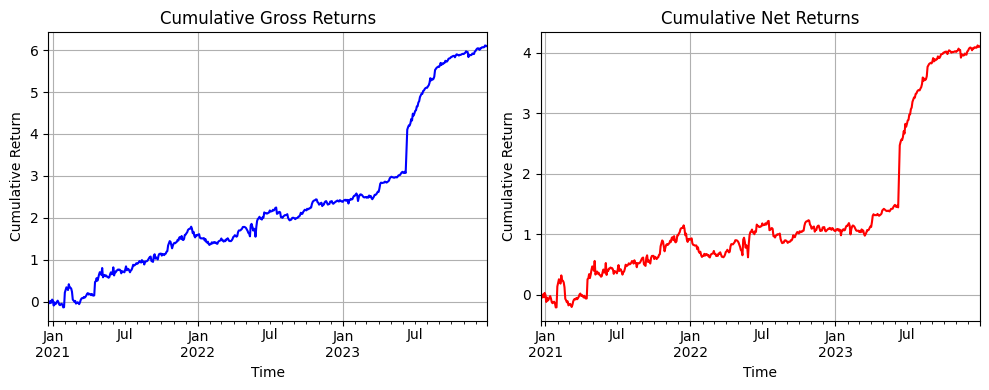

In [16]:
gross_returns, net_returns, traded_prices = get_variant_gross_and_net_returns(
    12, horizon_to_px_4h[12], 48, SignalType.RANK_THRESHOLD, RankType.NOT_RANKED, 0.05
)

plot_gross_and_net_cumulative_returns(gross_returns, net_returns)

In [17]:
pd.Series(get_strategy_stats(net_returns, 48, traded_prices)).to_frame()

,0
avg returns,1.353102
decorrelated avg returns,1.336768
volatility,0.802799
sharpe ratio,1.685480
decorrelated sharpe ratio,1.664827
max drawdown,-7.701955
max drawdown duration,182.000000
alpha_BTC,0.007340
beta_BTC,0.046078


## Testing Period

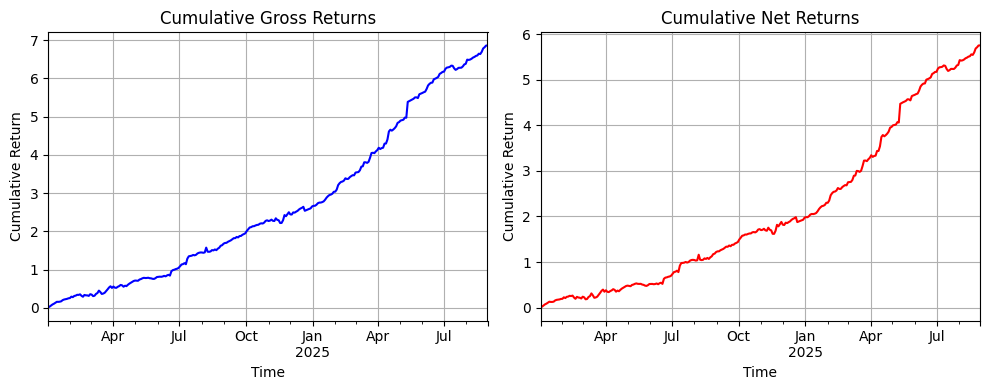

In [18]:
gross_returns, net_returns, traded_prices = get_variant_gross_and_net_returns(
    12, horizon_to_px_total_period[12], 48, SignalType.RANK_THRESHOLD, RankType.NOT_RANKED, 0.05
)

test_gross_returns = gross_returns.loc[t:]
test_net_returns = net_returns.loc[t:]

plot_gross_and_net_cumulative_returns(test_gross_returns, test_net_returns)

In [19]:
pd.Series(get_strategy_stats(test_net_returns, 48, traded_prices.loc[t:])).to_frame()

,0
avg returns,3.451894
decorrelated avg returns,3.401973
volatility,0.564995
sharpe ratio,6.109599
decorrelated sharpe ratio,6.029614
max drawdown,-0.307030
max drawdown duration,30.000000
alpha_BTC,0.018625
beta_BTC,0.093919
